# Housing costs: based on ACS

### Preparation:import needed package

In [1]:
# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from census import Census
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
from us import states
import pyproj
import geopandas as gpd
import numpy as np
from configparser import ConfigParser

### Preparation: load stored files

In [3]:
# Read all environment variables
config = ConfigParser()
config.readfp(open(r'Config.py'))

census_api = config.get('General',"census_api") # api key
tx_state = config.get('General',"tx_state") #tx_state shapefile
tx_county  = config.get('General',"tx_county") # tx_county shapefile
tx_bgs = config.get('General',"tx_bgs") # tx_bgs shapefile

In [4]:
# Set ACS API key
c = Census(census_api) 

In [5]:
# Access shapefile of Texas state
tx_state = gpd.read_file(tx_state) 

# Access shapefile of Texas county
tx_county = gpd.read_file(tx_county)

# Access shapefile of Texas census block groups
tx_bgs = gpd.read_file(tx_bgs)

## A. Download ACS data and corresponding geometry at block group level

our target variables:
* monthly rent_cost = "B25064_001E", 
* monthly housing_mortgage = "B25088_002E",
* Median household income (in 2019 inflation-adjusted dollar) = "B19013_001E",
* total number of commuter (all travel mode) = "B08301_001E",
* Total population in occupied housing units by tenure = "B25008_001E",
* total population = "B01003_001E",
* household size = "B25010_001E",
* the number of households = "B11001_001E",
* the number of housingUnits = "B25001_001E",
* the number of owner-occupied housing units = "B25003_002E",
* the number of renter-occupied housing units = "B25003_003E",
* aggregate number of vehicles available = "B25046_001E",
* the number of public_transit commuters= "B08301_010E",
* hte number of drivealone commuters= "B08301_003E"

In [6]:
###Load Campo region's ACS Data at the block groups level###

# census data download
bgs_census = c.acs5.state_county_blockgroup(fields = ('NAME', 'B25064_001E','B25088_002E','B19013_001E','B08301_001E','B25008_001E','B01003_001E','B25010_001E',
          'B11001_001E','B25001_001E','B25003_002E','B25003_003E','B25046_001E','B08301_010E','B08301_003E'), #public_transit users "B08301_010", number of household = "B11001_001"
                                            state_fips = states.TX.fips,
                                            county_fips = "*",
                                            blockgroup = "*",
                                            year = 2019)  # you might need to update the "year" based on your needs, if you want to use "2015-2019", then type "year = 2019"  
# Create a dataframe for the downloaded census data
bgs_census = pd.DataFrame(bgs_census)

# rename each variables with more intuitive names
column_names = ['NAME','rent_cost', 'housing_mortgage','medincome','commuter','pop_housing','totpop','HHsize'
               ,'HH','HousingUnits','OwnerUnits','RentalUnits','vehicle','public_transit','drivealone',
                'state','county','tract','block group']

bgs_census.columns = column_names

# filter needed county (CAMPO's counties fips:#Bastrop =021,Burnet=053,Caldwell=055,Hays =209,Travis=453,Williamson = 491)

county = ['021', '053', '055','209','453','491']
bgs_census = bgs_census[bgs_census['county'].isin(county)] 

# Show the dataframe
# print('Shape: ', bgs_census.shape)
# bgs_census.info() # review 

In [7]:
### Create GEOID for each block groups: ###

# Combine state, county, tract, and block group columns to create a new string and assign it to a new column

bgs_census["geoid"] = bgs_census["state"] + bgs_census["county"] + bgs_census ["tract"] + bgs_census ["block group"]

# Remove columns that are no longer needed
bgs_census = bgs_census.drop(columns = ["state", "county","tract","block group","NAME"])

# change the order of the column
cols = bgs_census.columns.tolist()
cols = cols[-1:] + cols[:-1] #move "geoid" column forward to the front
bgs_census = bgs_census[cols] #apply the new column sequence 


In [8]:
### Clean Data ###
#Some variables have negative values, which means they are invalid values.
# we convert that to 0 to avoid calculation errors in other steps
num = bgs_census._get_numeric_data()
num[num < 0] = 0 

## B. import shapefile from TIGER/LINE

In [9]:
### State's Shapfile ###


# Reproject shapefile to the EPSG identifier of NAD83
tx_state  = tx_state.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_state  = tx_state [['GEOID','NAME','geometry']]

# rename columns to lower case
tx_state.columns= tx_state.columns.str.lower()


# narrow down to TX state area
state = ['48']
tx_state   = tx_state [tx_state ['geoid'].isin(state)] 

tx_state ['namelsad'] = tx_state ['name'] # in order to plotting the names


### County's Shapfile ###


# Reproject shapefile to the EPSG identifier of NAD83
tx_county = tx_county.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_county = tx_county[['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_county.columns= tx_county.columns.str.lower()


# narrow down to CAMPO county
county = ['48021', '48053', '48055','48209','48453','48491']
campo_county = tx_county[tx_county['geoid'].isin(county)]
campo_county.reset_index(drop=True, inplace=True)

campo_county ['namelsad'] = campo_county ['name'] # in order to plotting the names


### Block groups' Shapfile ###

# Reproject shapefile to the EPSG identifier of NAD83
tx_bgs = tx_bgs.to_crs(epsg = 4269)

#clean data through keeping only necessary variables

tx_bgs = tx_bgs[['GEOID', 'ALAND','geometry']]

# rename  columns to lower case
tx_bgs.columns= tx_bgs.columns.str.lower()

## C. Merge dataframes: join the two dataframes (acs and tiger shapefile)

In [10]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
tx_acs = tx_bgs.merge(bgs_census, on = "geoid")

# Show result
print('Shape: ', tx_acs.shape);

tx_acs.head(2)

Shape:  (994, 17)


,geoid,aland,geometry,rent_cost,housing_mortgage,medincome,commuter,pop_housing,totpop,HHsize,HH,HousingUnits,OwnerUnits,RentalUnits,vehicle,public_transit,drivealone
0,480539607001,25087836,"POLYGON ((-98.29806 30.59752, -98.29801 30.597...",0.0,1148.0,78521.0,621.0,1664.0,1675.0,2.75,606.0,666.0,361.0,245.0,934.0,0.0,615.0
1,480539603002,10257531,"POLYGON ((-98.23087 30.76786, -98.23051 30.767...",669.0,1566.0,55838.0,684.0,1280.0,1287.0,3.26,393.0,393.0,231.0,162.0,886.0,0.0,381.0


In [11]:
#### get weighted total housing costs by the ratio of owner- to renter-occupied housing units from the tenure variable for every block group###

tx_acs ['ratio'] =tx_acs ['OwnerUnits']/tx_acs ['RentalUnits']

## check whether there has null varaibles in the results

#tx_acs ['ratio'].isnull().values.any()
# tx_acs[tx_acs ['ratio'].isnull()].index.tolist()

### assign 0 values to those null results
tx_acs ['ratio'] = tx_acs ['ratio'].replace(np.nan, 1)
tx_acs ['ratio'] = tx_acs ['ratio'].replace([np.inf, -np.inf], 1)  


# get average weighted housing costs per month
tx_acs ['ave_housing_monthly'] =  ((tx_acs ['ratio'] * tx_acs ['housing_mortgage'])+ tx_acs ['rent_cost'])/(tx_acs ['ratio']+1)


# get average weighted housing costs per year 
tx_acs ['ave_housing_yearly'] = 12* tx_acs ['ave_housing_monthly']




In [12]:
# export necessary varibles to csv
tx_acs1 = tx_acs [['geoid','medincome','totpop','rent_cost','housing_mortgage','ave_housing_yearly','ave_housing_monthly','HHsize']]
tx_acs1.to_csv('housing.csv',index=False)

## D. Plotting/mapping

### D.1) Housing mortgage cost distribution

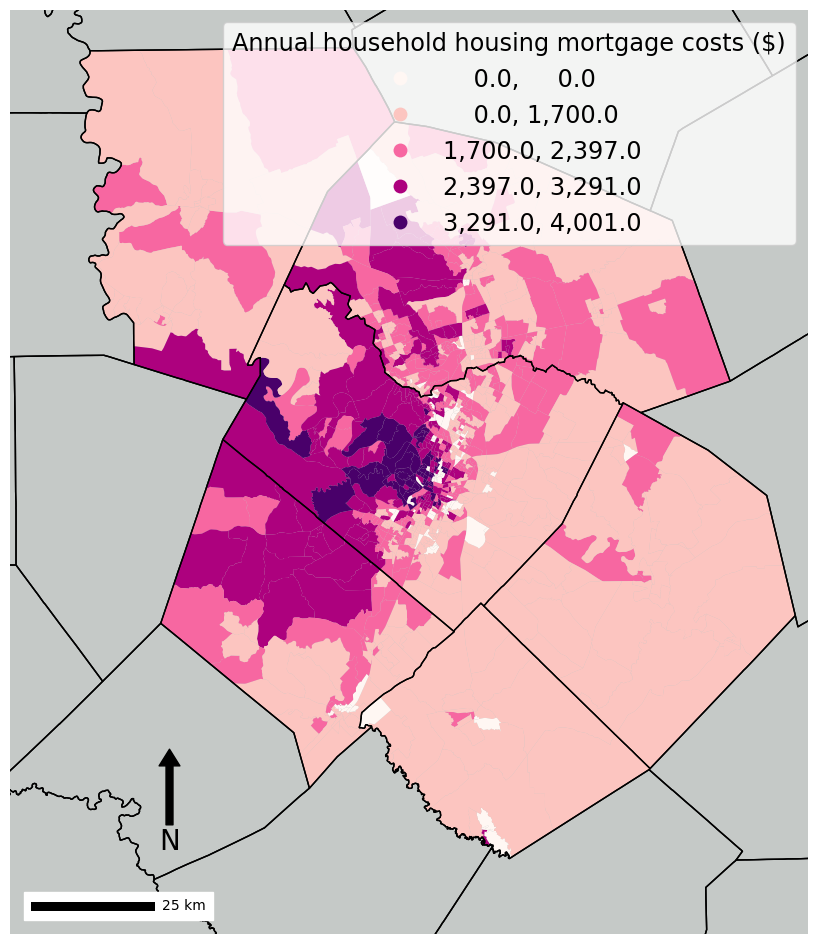

In [13]:
# Create single comprehensive subplots

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size

ax.axis([-98.6,-97,29.5,31.1]) # set axis

# plot county boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2) 
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)


 # plot selected variable
tx_acs.plot(column = "housing_mortgage",
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)
ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household housing mortgage costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower left"))

# add North arrow
x, y, arrow_length = 0.2, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig('images/annual_housing_mortgage_costs.png')

### D.2) Housing rent cost distribution

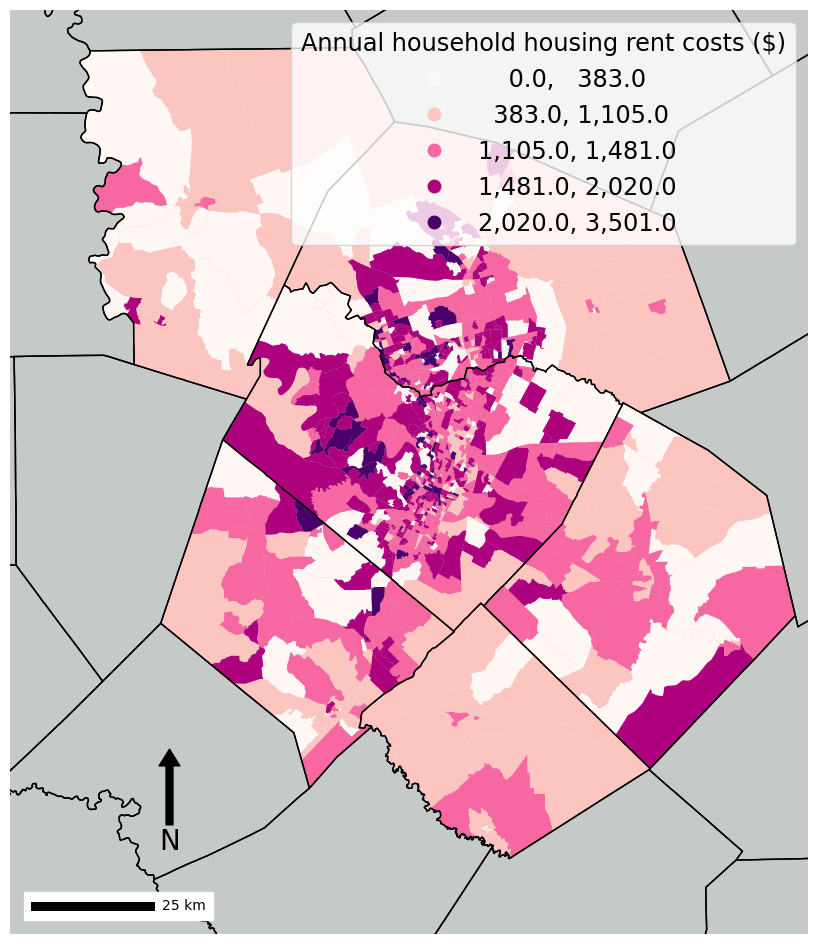

In [14]:
# Create single comprehensive subplots

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size

ax.axis([-98.6,-97,29.5,31.1]) # set axis

# plot county boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2) 
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)

 # plot selected variable
tx_acs.plot(column = "rent_cost", # plot selected variable
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)
ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household housing rent costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower left"))

# add North arrow
x, y, arrow_length = 0.2, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig('images/annual_housing_rent_costs.png')

### D.3) Average weighted housing costs (weighted rent and mortgage)

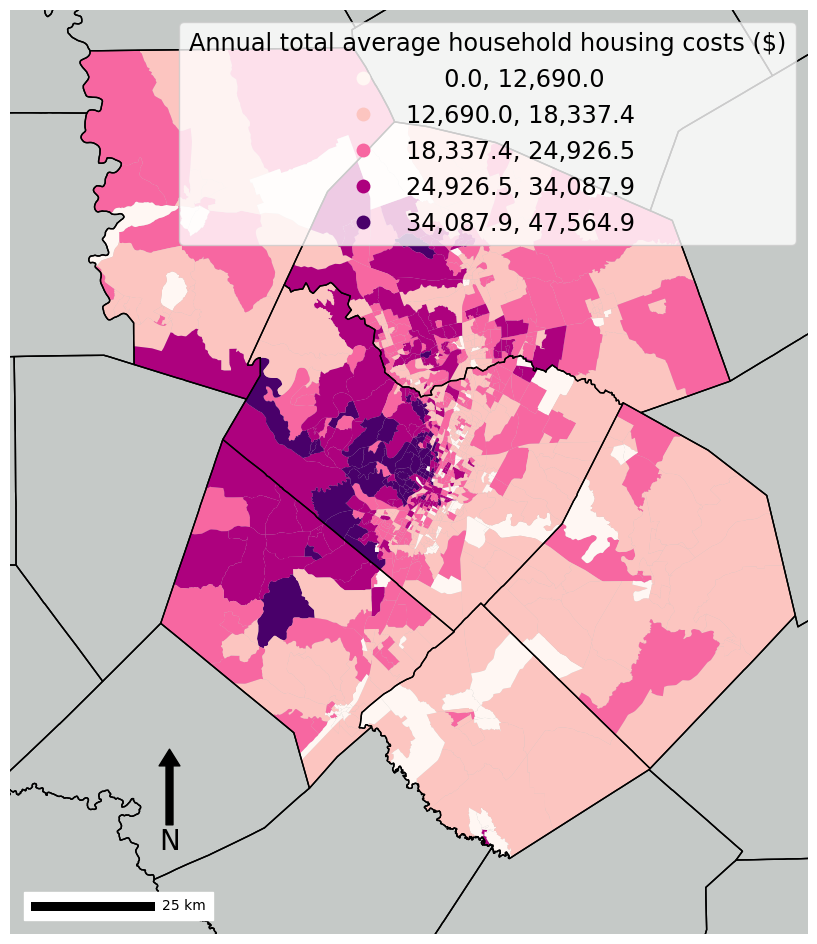

In [15]:
# Create single comprehensive subplots

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size

ax.axis([-98.6,-97,29.5,31.1]) # set axis

# plot county boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2) 
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)


 # plot selected variable
tx_acs.plot(column = "ave_housing_yearly", # plot selected variable
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)
ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual total average household housing costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower left"))

# add North arrow
x, y, arrow_length = 0.2, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig('images/annual_total_housing_costs.png')